<a href="https://colab.research.google.com/github/saty5655/-Solar-Panel-Inspection-using-CNN/blob/main/Solar_Panel_Inspection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'solar-panel-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3365061%2F5889548%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240922%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240922T064434Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D478a284becf974cf6ddcba8357799e13a2f5470f4605c94fd29e07fcc7c521cc39010807de747580d0d3276bf5a8d76b042e6e3dd94ebefda7ee20b8a18aeb91d211796a50ea212ced0aa07f66b07b5df4034e83d26b192256f72787422f7cd42f95f7626b18ded7fda1974d10af25fdb6f3028c2d77683b6a5bdce42f3f6130487062df0d772454e5467ecfe60573d6f11c2654c0d1de5713a44f75753546024607115bcd5d9adac30728a3f51c09395db29057b6e4965d514712bbfbf4e6a8db7c09bc80d1e907e3cae4adca5d9cc90af477b9828e45ccaf3475cd43420d457f5c0987924caa8320535741d4266d1ee68d2ca9bc737d3bce6e385c856f8d81'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 319746451 bytes downloaded
Downloaded and uncompressed: solar-panel-images
Data source import complete.


In [ ]:


import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (117).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (91).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (7).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (8).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (124).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (6).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (174).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (41).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (3).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (169).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (100).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (175).jpg
/kaggle/input/solar-panel-images/Faulty_solar_panel/Clean/Clean (103).jpg
/kaggle/input/solar-panel-images/Faulty_solar_pa

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import random
from cv2 import resize
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Reading the Dataset
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/solar-panel-images/Faulty_solar_panel',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/solar-panel-images/Faulty_solar_panel',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [ ]:
# Checking the Classes
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

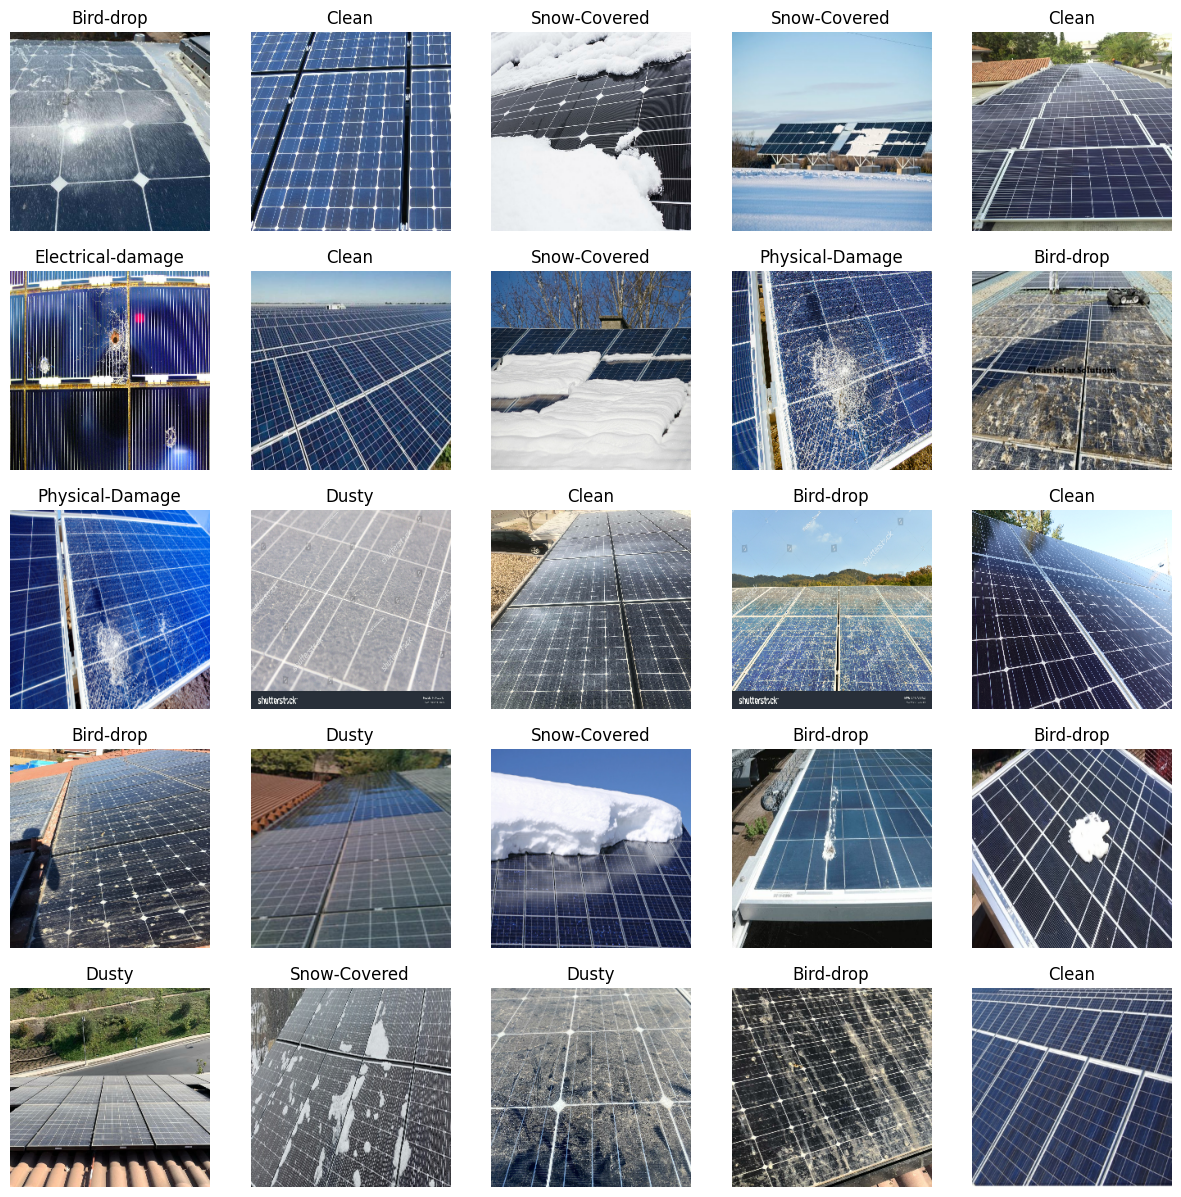

In [ ]:
# Checking Training Data
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### VGG-16

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 244, 244, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 244, 244, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 90)             │         46,170 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,760,858 (56.31 MB)

 Trainable params: 46,170 (180.35 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.8 MB/s eta 0:00:00


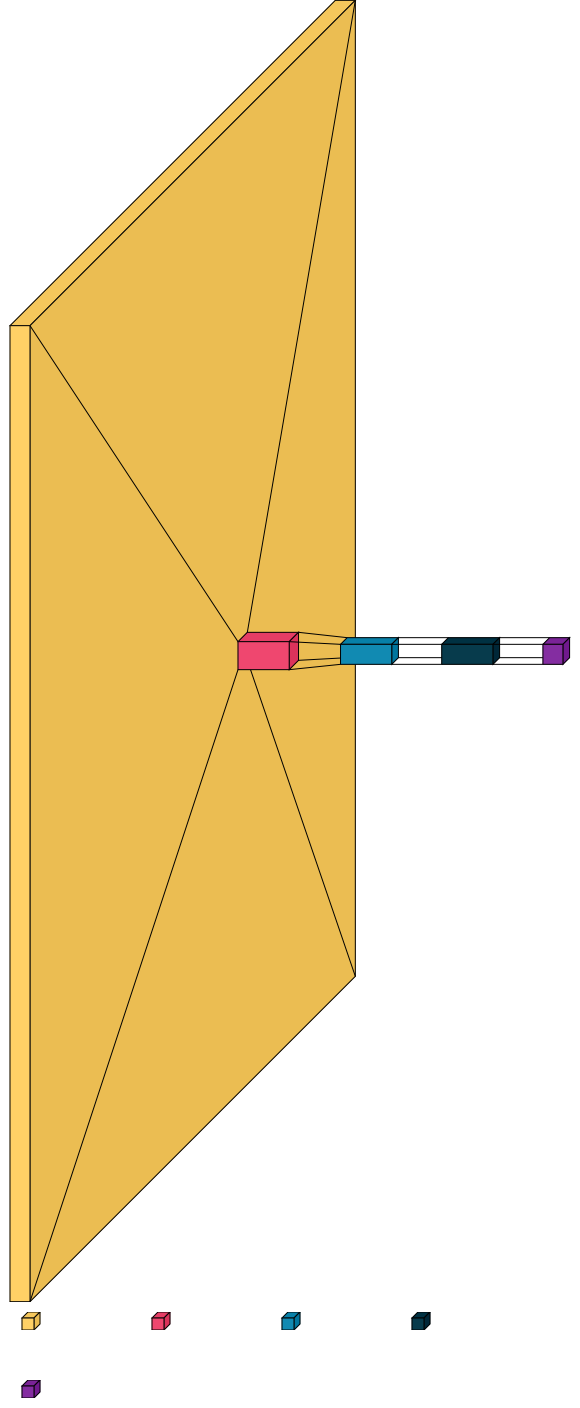

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model,legend=True,spacing=50,background_fill = 'white')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epoch = 15
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 700s 30s/step - accuracy: 0.0245 - loss: 13.8124 - val_accuracy: 0.1299 - val_loss: 5.0119
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 661s 29s/step - accuracy: 0.2062 - loss: 5.3341 - val_accuracy: 0.2712 - val_loss: 3.0549
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 681s 29s/step - accuracy: 0.3274 - loss: 3.6794 - val_accuracy: 0.4407 - val_loss: 2.0874
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 656s 29s/step - accuracy: 0.4298 - loss: 2.7442 - val_accuracy: 0.4972 - val_loss: 1.8895
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 684s 29s/step - accuracy: 0.5079 - loss: 2.1696 - val_accuracy: 0.5763 - val_loss: 1.5107
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 677s 29s/step - accuracy: 0.5453 - loss: 1.8242 - val_accuracy: 0.6045 - val_loss: 1.3618
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 682s 28s/step - accuracy: 0.6122 - loss: 1.6546 - val_accuracy: 0.6215 - val_loss: 1.2469
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 683s 29s/step - accuracy: 0.6376 - loss: 1.6097 - val_accuracy: 0

In [ ]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 244, 244)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 244, 244, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 244, 244, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 90)             │         46,170 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,853,200 (56.66 MB)

 Trainable params: 7,125,594 (27.18 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 92,342 (360.71 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()


NameError: name 'history' is not defined

In [ ]:
model.save('solar_panel_inspection.hdf5')

# Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 131s 21s/step - accuracy: 0.7511 - loss: 0.9381
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


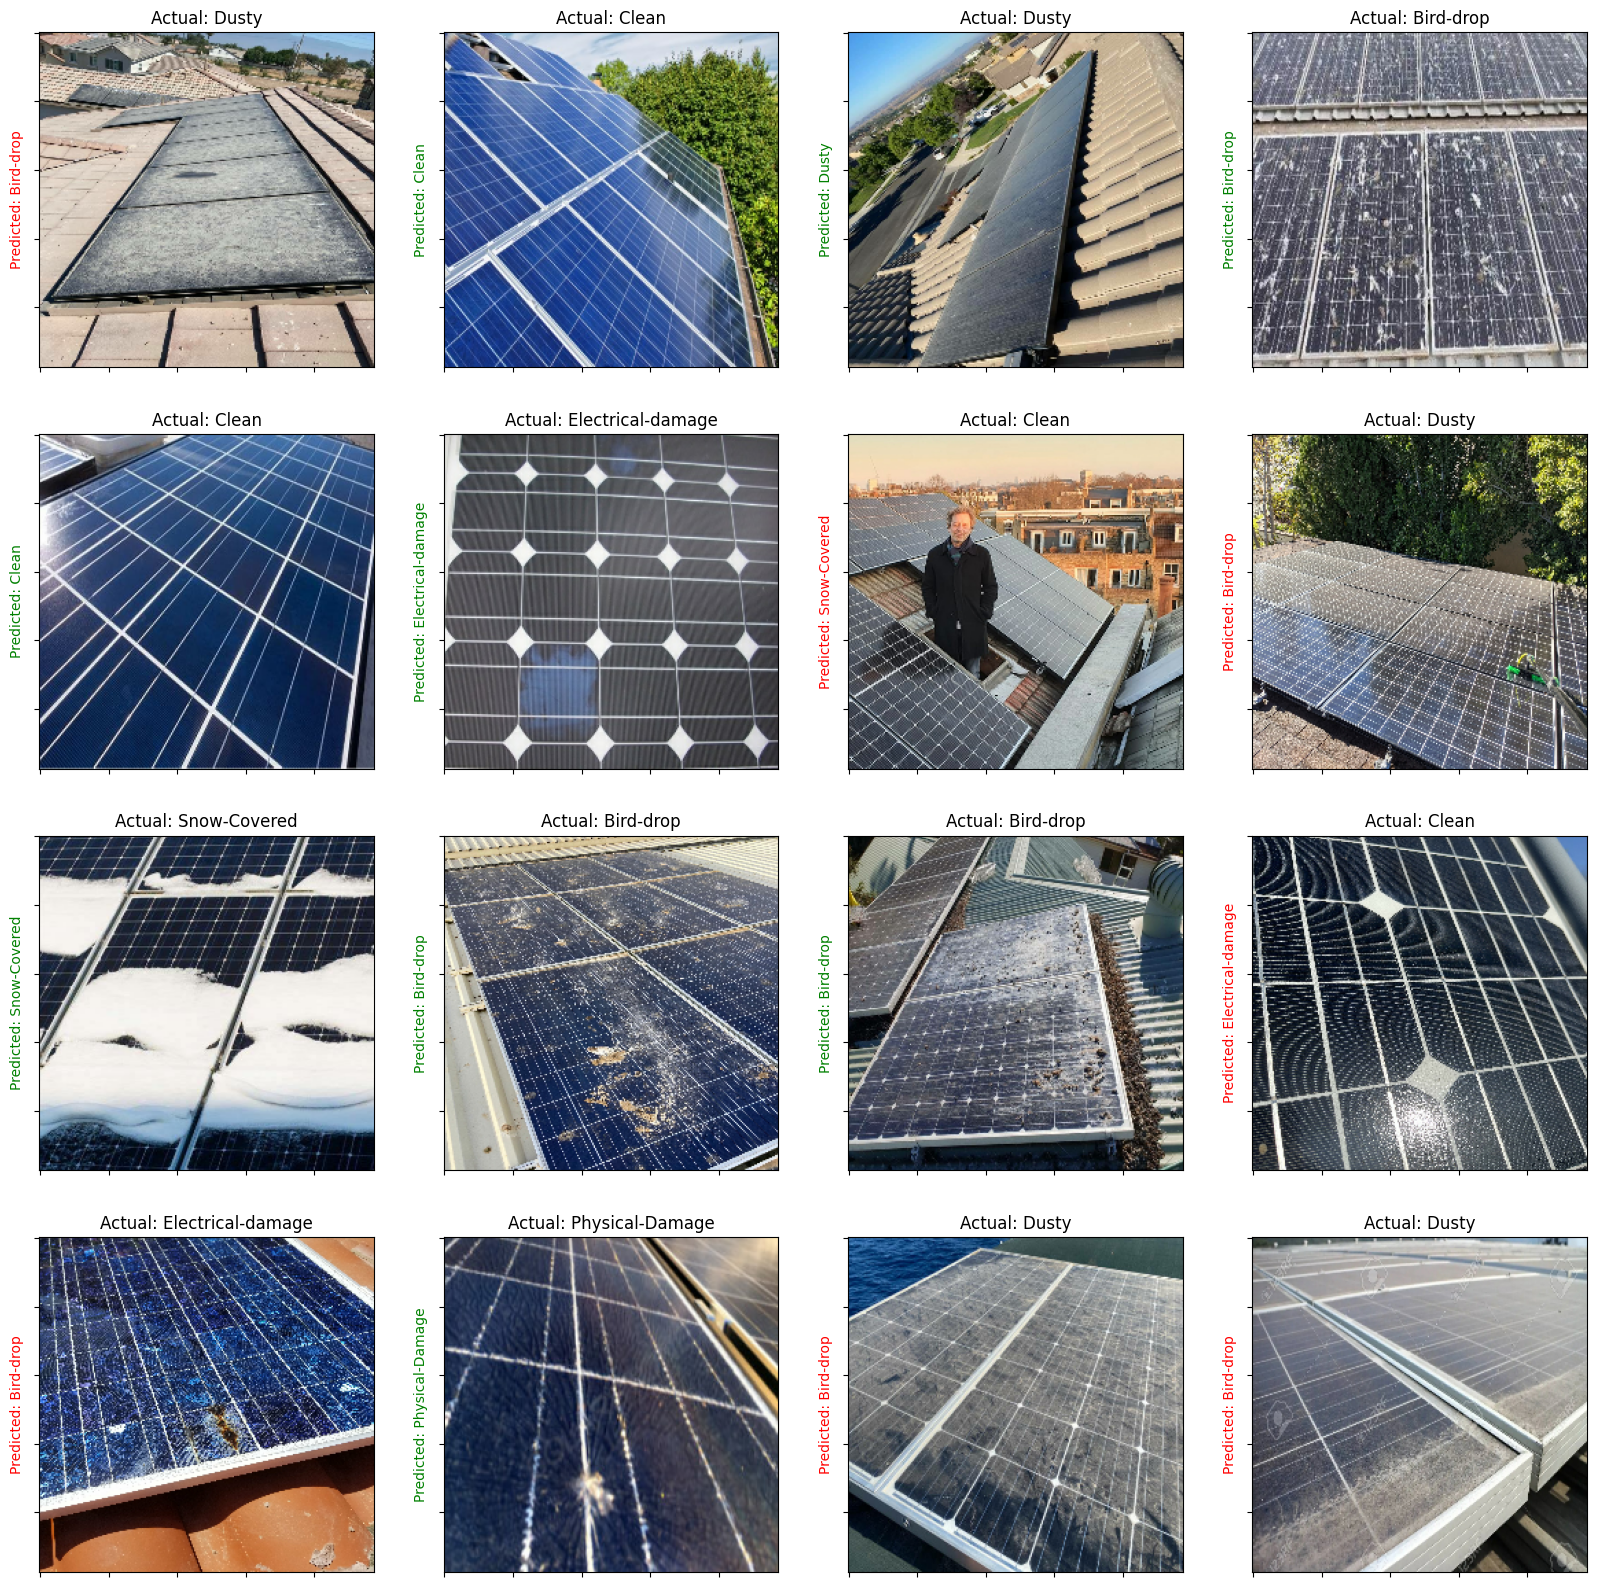

In [ ]:
loss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])